In [42]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

# Load Data
selected_features_labeled = pd.read_csv("selected_features.csv", sep='\t')

In [26]:
## data cleaning

# Check for missing values and zero-value columns
zero_counts = (selected_features_labeled == 0).sum()
print("Total missing values: ", selected_features_labeled.isnull().sum().sum())
print("Missing values per column:\n", selected_features_labeled.isnull().sum())
print("Columns with all zero values:\n", zero_counts)

# Drop unnecessary columns
selected_features_labeled = selected_features_labeled.drop(columns=['DID040', 'DIQ220', 'DIQ230', 'DID260', 'DIQ280', 'DIQ300S', 'DIQ300D'], errors='ignore')

# Drop rows where certain columns contain zeros
cols_to_check = ['LBXAPB', 'LBDINSI', 'LBXGH', 'PADDURAT', 'RIDAGEMN']
selected_features_labeled = selected_features_labeled[(selected_features_labeled[cols_to_check] != 0).all(axis=1)]

# Save cleaned data
selected_features_labeled.to_csv("selected_features_final.csv", sep='\t', index=False)


Total missing values:  0
Missing values per column:
 SEQN        0
BPQ020      0
DIQ010      0
DIQ190A     0
DIQ190B     0
PAQ180      0
PADACTIV    0
PADDURAT    0
SLD010H     0
LBXAPB      0
LBDINSI     0
LBXGH       0
RIAGENDR    0
RIDAGEMN    0
dtype: int64
Columns with all zero values:
 SEQN        0
BPQ020      0
DIQ010      0
DIQ190A     0
DIQ190B     0
PAQ180      0
PADACTIV    0
PADDURAT    0
SLD010H     0
LBXAPB      0
LBDINSI     0
LBXGH       0
RIAGENDR    0
RIDAGEMN    0
dtype: int64


In [24]:
## preDM filter

# Reload cleaned dataset
combined_selected_features = pd.read_csv("selected_features_final.csv", sep='\t')

# Define PreDM condition
preDM_criteria = (combined_selected_features['LBDINSI'] >= 100) | (combined_selected_features['LBXAPB'] >= 110) | (combined_selected_features['LBXGH'] >= 5.5)

# Add 'PreDM' label
combined_selected_features['PreDM'] = preDM_criteria.astype(int)

# Drop features used for labeling
combined_selected_features = combined_selected_features.drop(columns=['LBDINSI', 'LBXAPB', 'LBXGH'], errors='ignore')

# Save final labeled dataset
combined_selected_features.to_csv("selected_features_labeled_final.csv", sep='\t', index=False)


In [25]:
# prepare data for analysis, train/test
# Load labeled dataset
labeled_selected_features = pd.read_csv("selected_features_labeled_final.csv", sep='\t')

# Define features and target
X = labeled_selected_features[['BPQ020', 'DIQ010', 'DIQ190A', 'DIQ190B', 'PAQ180', 'PADACTIV', 'PADDURAT', 'SLD010H', 'RIAGENDR', 'RIDAGEMN']]
y = labeled_selected_features["PreDM"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.7, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [5]:
## train/evaluate model

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)
y_pred_dt = dt_model.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt:.2f}\n", classification_report(y_test, y_pred_dt))

# Logistic Regression
log_reg = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)
accuracy_log = accuracy_score(y_test, y_pred_log_reg)
print(f"Logistic Regression Accuracy: {accuracy_log:.2f}\n", classification_report(y_test, y_pred_log_reg))

# XGBoost
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train, verbose=False)
y_pred_xgb = xgb_model.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.2f}\n", classification_report(y_test, y_pred_xgb))


Decision Tree Accuracy: 0.83
               precision    recall  f1-score   support

           0       0.82      0.81      0.81       427
           1       0.83      0.84      0.84       481

    accuracy                           0.83       908
   macro avg       0.83      0.83      0.83       908
weighted avg       0.83      0.83      0.83       908

Logistic Regression Accuracy: 0.67
               precision    recall  f1-score   support

           0       0.63      0.75      0.68       427
           1       0.73      0.61      0.66       481

    accuracy                           0.67       908
   macro avg       0.68      0.68      0.67       908
weighted avg       0.68      0.67      0.67       908

XGBoost Accuracy: 0.81
               precision    recall  f1-score   support

           0       0.79      0.81      0.80       427
           1       0.82      0.81      0.82       481

    accuracy                           0.81       908
   macro avg       0.81      0.81     

In [31]:
## cross-validation of models

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Decision Tree CV
dt_scores = cross_val_score(DecisionTreeClassifier(random_state=42), X_train_scaled, y_train, cv=kf, scoring='f1')
print(f"Decision Tree Mean CV Accuracy: {dt_scores.mean():.2f}")

# Logistic Regression CV
lr_scores = cross_val_score(LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42), X_train_scaled, y_train, cv=kf, scoring='f1')
print(f"Logistic Regression Mean CV Accuracy: {lr_scores.mean():.2f}")

# XGBoost CV
xgb_scores = cross_val_score(xgb.XGBClassifier(eval_metric='logloss', random_state=42, alpha=0.5), X_train_scaled, y_train, cv=kf, scoring='f1')
print(f"XGBoost Mean CV Accuracy: {xgb_scores.mean():.2f}")


Decision Tree Mean CV Accuracy: 0.77
Logistic Regression Mean CV Accuracy: 0.63
XGBoost Mean CV Accuracy: 0.77


In [ ]:
## confusion matrix using XGBoost model

# Function to plot confusion matrix
def plot_confusion_matrix(cm, fold_num):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Fold {fold_num}")
    #plt.savefig('final_visualizations/confusion_matrix.png')
    #plt.show()

# XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42, alpha=0.5)

fold_cm = []
total_samples = 0
all_predictions = np.zeros(len(y))  # Start with zeros for all predictions

for fold_num, (train_index, test_index) in enumerate(kf.split(X, y), start=1):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    xgb_model.fit(X_train_cv, y_train_cv)
    y_pred_cv = xgb_model.predict(X_test_cv)

    all_predictions[test_index] = y_pred_cv

    #print(y_pred_cv)

    cm = confusion_matrix(y_test_cv, y_pred_cv)
    fold_cm.append(cm)

    print(f"Confusion Matrix for Fold {fold_num}: \n{cm}\n")

     # Plot confusion matrix after each fold
    #plot_confusion_matrix(cm, fold_num)

# Compare predictions to actual values and label them as correct (1) or incorrect (0)
correct_predictions = (all_predictions == y).astype(int)

labeled_selected_features["Prediction_Correct"] = correct_predictions
    
labeled_selected_features.to_csv("selected_features_labeled_final_with_predictions.csv", sep='\t', index=False)

# Count of correct predictions (where Prediction_Correct == 1)
correct_count = labeled_selected_features["Prediction_Correct"].sum()

# Count of incorrect predictions (where Prediction_Correct == 0)
incorrect_count = len(labeled_selected_features) - correct_count

# Print the results
print(f"Correct Predictions: {correct_count}")
print(f"Incorrect Predictions: {incorrect_count}")

print(correct_predictions)


Confusion Matrix for Fold 1: 
[[352  75]
 [ 96 385]]

Confusion Matrix for Fold 2: 
[[386  68]
 [ 76 377]]

Confusion Matrix for Fold 3: 
[[396  80]
 [ 90 341]]

Confusion Matrix for Fold 4: 
[[360  80]
 [ 89 378]]

Confusion Matrix for Fold 5: 
[[390  80]
 [ 93 344]]

Correct Predictions: 3709
Incorrect Predictions: 827
0       1
1       1
2       1
3       1
4       1
       ..
4531    0
4532    1
4533    1
4534    1
4535    0
Name: PreDM, Length: 4536, dtype: int64


In [ ]:
# comparison of correct and wrong values
correct = labeled_selected_features[labeled_selected_features['Prediction_Correct']==1]
wrong = labeled_selected_features[labeled_selected_features['Prediction_Correct']==0]

In [ ]:
correct_desc = correct.describe()
wrong_desc = wrong.describe()

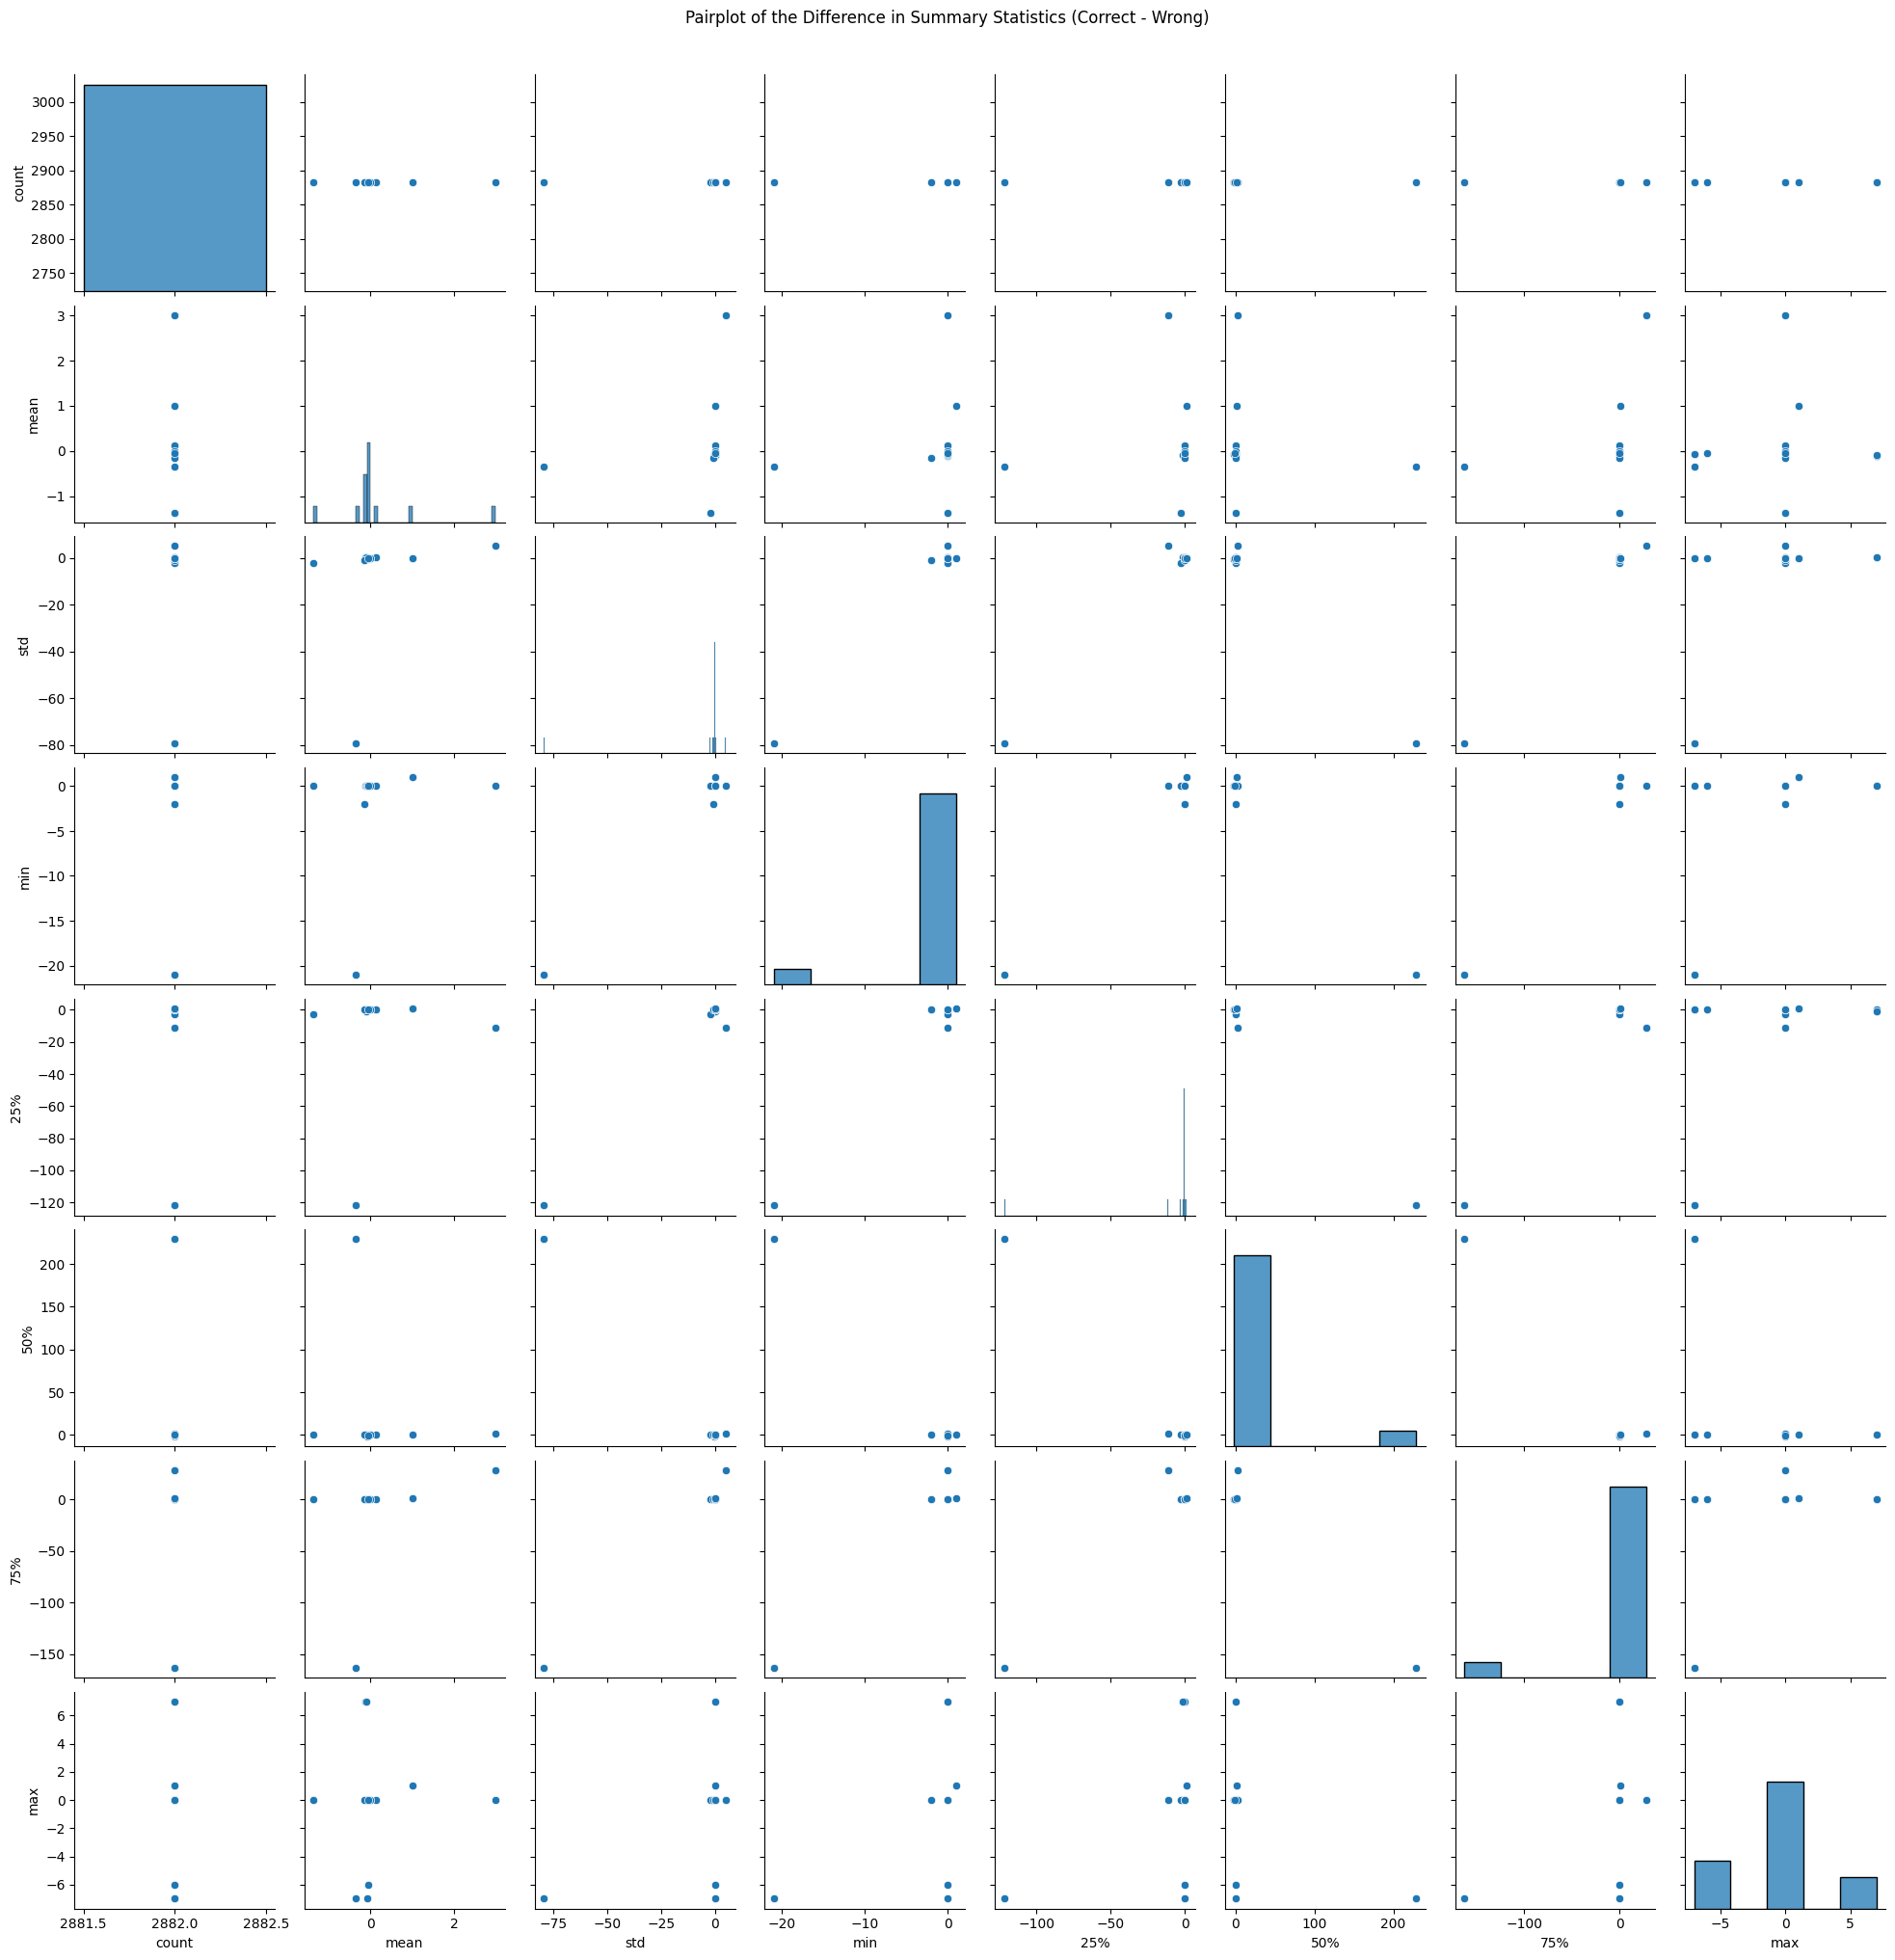

In [70]:
difference = correct_desc - wrong_desc

# Print the difference
# print("Difference between correct and wrong predictions summary statistics:")
# print(difference)

difference.to_csv("selected_features_final_with_predictions_difference.csv", sep='\t')

## pairplot of difference
# Transpose the difference to make it suitable for pairplot (each column represents a feature)
difference_transposed = difference.T

# Create a pairplot of the difference
sns.pairplot(difference_transposed)
plt.suptitle("Pairplot of the Difference in Summary Statistics (Correct - Wrong)", y=1.02)
plt.savefig("final_visualizations/pairplot_difference_statistics.png")

plt.show()